In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload

%autoreload 2

%matplotlib notebook
sns.set()

In [ ]:
import galsim
from mdetsims import Sim

In [ ]:
%%time

sim = Sim(
    rng=np.random.RandomState(seed=3327),
    g1=0.02,
    gal_type='ground_galsim_parametric',
    scale=0.263,
    psf_type='ps',
    n_coadd=30,
    n_coadd_psf=1,
    psf_kws={'trunc': 1})
mbobs = sim.get_mbobs()

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(mbobs[0][0].image, square=True)

In [ ]:
psf_obs1 = sim.get_psf_obs(x=0, y=30)
psf_obs2 = sim.get_psf_obs(x=10, y=120)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

sns.heatmap(psf_obs1.image, square=True, ax=axs[0])

sns.heatmap((psf_obs2.image - psf_obs1.image) / np.max(psf_obs1.image), square=True, ax=axs[1])

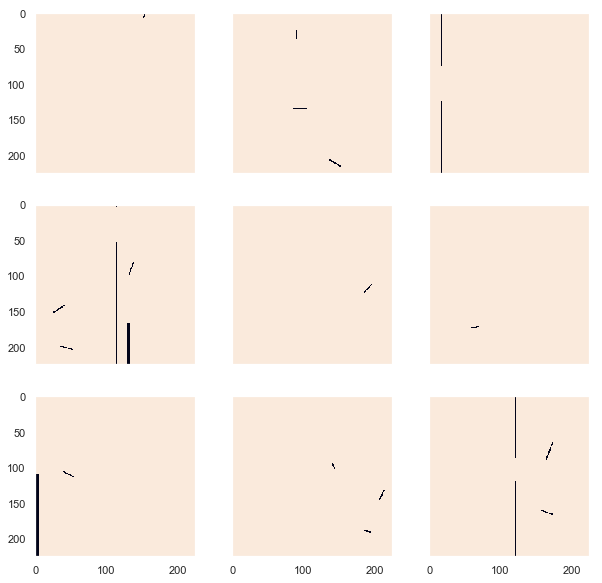

In [18]:
from mdetsims.masking import generate_bad_columns, generate_cosmic_rays

fig, axs = plt.subplots(nrows=3, ncols=3, sharex='all', sharey='all', figsize=(10, 10))

for ax in axs.ravel():
    msk = np.zeros((225, 225)).astype(bool)
    msk |= generate_cosmic_rays(msk.shape)
    msk |= generate_bad_columns(msk.shape)
    ax.imshow(1-msk, vmin=0, vmax=1)
    ax.grid(False)